## Images Visual Relationship project
This project is based on the [Google AI Open Images - Visual Relationship Track Kaggle Challenge](https://www.kaggle.com/c/google-ai-open-images-visual-relationship-track).

The challenge is to build the best performing algorithm for automatically detecting relationships triplets.

In [1]:
import argparse
import csv
import pickle
import os
import sys
import random
import math
import re
import time
import wget
import numpy as np
from PIL import Image
import cv2
import glob
from shutil import copyfile
import collections
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
import parallel 
import concurrent.futures

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import __version__ as keras_version
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Cropping2D, Reshape, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import concatenate
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Visualizations will be shown in the notebook.
%matplotlib inline

# https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb
import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image, compute_resize_scale
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

#def get_session():
#    config = tf.ConfigProto()
#    config.gpu_options.allow_growth = True
#    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
#keras.backend.tensorflow_backend.set_session(get_session())

# Directory to save logs and trained model
# https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5
RCNN_COCO_MODEL_URL = "https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5"
RCNN_COCO_MODEL = "resnet50_coco_best_v2.1.0.h5"

# Local path to trained weights file
MODEL_PATH = os.path.join(os.path.join(os.getcwd(), "pretrained_models"), RCNN_COCO_MODEL)

# Download COCO trained weights from Releases if needed
if not os.path.exists(MODEL_PATH):
    print ('Downloading COCO trained weights: {} to path: {}'.format(RCNN_COCO_MODEL, MODEL_PATH))  
    wget.download(RCNN_COCO_MODEL_URL, MODEL_PATH)  
else:
    print ('Using COCO trained weights: {} from path: {}, downloaded from: {}'.format(
        RCNN_COCO_MODEL, MODEL_PATH, RCNN_COCO_MODEL_URL))
    
import warnings
warnings.simplefilter('ignore', UserWarning)

print ('Keras version: {}'.format(keras_version))
print ('Tensorflow version: {}'.format(tf.__version__))
print ('Tensorflow lib config: {}'.format(tf.sysconfig.get_lib()))

from helpers import get_fid, process_labels_from_csv_input, process_raw_csv_input, get_data_dir_from_raw_single_dir 
from helpers import get_data_from_dir_recursive, bounding_box_to_plt, two_bounding_boxes_to_plt, show_images
from helpers import show_given_images, show_random_images, _resize_job_helper, chunks, resize_all

Using TensorFlow backend.


Using COCO trained weights: resnet50_coco_best_v2.1.0.h5 from path: /home/powell/work/scpd/vision_project/visual_relationship/pretrained_models/resnet50_coco_best_v2.1.0.h5, downloaded from: https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5
Keras version: 2.2.4
Tensorflow version: 1.4.0
Tensorflow lib config: /home/powell/ENTER/envs/carnd-term1/lib/python3.5/site-packages/tensorflow


In [3]:
annotations_file='fullsize_train_annotations.csv'
annotations_test_file='fullsize_test_annotations.csv'
classes_file='fullsize_classes.csv'
# Load the labels
label_tag_to_name = process_labels_from_csv_input()
def load_labels(label_tag_to_name, labels_file=classes_file):
    labels_to_names = {}
    # Process the labels info files and create a key value pair
    with open(labels_file, encoding='utf8') as f:
        rows = csv.reader(f)
        for row in rows:
            labels_to_names[int(row[1])]= (label_tag_to_name[row[0]], row[0])
    return labels_to_names

labels_to_names = load_labels(label_tag_to_name, labels_file=classes_file)
#print(label_tag_to_name)
print ("Number of labels loaded:{}".format(len(labels_to_names)))
for k, v in sorted(labels_to_names.items()):
    print ("{}: {}-{}".format(k, v[1], v[0]))

def load_labels_and_dataset_from_data(label_tag_to_name, data_file=annotations_file):
    labels_to_names = {}
    # Process the labels info files and create a key value pair
    with open(data_file, encoding='utf8') as f:
        rows = csv.reader(f)
        for row in rows:
            
            labels_to_names[row[-1]] = label_tag_to_name[row[-1]]
    return labels_to_names

train_labels_to_names = load_labels_and_dataset_from_data(label_tag_to_name, data_file=annotations_file)
print ("Number of unique labels from training data loaded: {}".format(len(train_labels_to_names)))
   
test_labels_to_names = load_labels_and_dataset_from_data(label_tag_to_name, data_file=annotations_test_file)
print ("Number of unique labels from test data loaded: {}".format(len(test_labels_to_names)))

missing_label_set = set(train_labels_to_names.keys()) - set(test_labels_to_names.keys())
print ("Total missing label count: {}".format(len(missing_label_set)))
for l in missing_label_set:
    print ("{}-{}".format(l, label_tag_to_name[l]))

Number of labels loaded:61
0: /m/078n6m-Coffee table
1: /m/01mzpv-Chair
2: /m/01226z-Football
3: /m/0h2r6-Van
4: /m/0pg52-Taxi
5: /m/0cvnqh-Bench
6: /m/0hg7b-Microphone
7: /m/0dnr7-Textile
8: /m/080hkjn-Handbag
9: /m/01f91_-Pretzel
10: /m/0k4j-Car
11: /m/078jl-Snake
12: /m/04_sv-Motorcycle
13: /m/0bwd_0j-Elephant
14: /m/02hj4-Dolphin
15: /m/029bxz-Oven
16: /m/019w40-Surfboard
17: /m/01s55n-Suitcase
18: /m/05r655-Girl
19: /m/01yrx-Cat
20: /m/05z87-Plastic
21: /m/03k3r-Horse
22: /m/050k8-Mobile phone
23: /m/0fx9l-Microwave oven
24: /m/0199g-Bicycle
25: /m/0h8my_4-Tennis racket
26: /m/04bcr3-Table
27: /m/07y_7-Violin
28: /m/04yx4-Man
29: /m/0584n8-Briefcase
30: /m/01599-Beer
31: /m/09tvcd-Wine glass
32: /m/0342h-Guitar
33: /m/04dr76w-Bottle
34: /m/0cmx8-Spoon
35: /m/026t6-Drum
36: /m/071p9-Ski
37: /m/0bt9lr-Dog
38: /m/08pbxl-Monkey
39: /m/03bt1vf-Woman
40: /m/01bl7v-Boy
41: /m/0l14j_-Flute
42: /m/04ctx-Knife
43: /m/05r5c-Piano
44: /m/0dv9c-Racket
45: /m/01940j-Backpack
46: /m/03ssj5-Bed
4

### Inspect the inference data and prep it for next stage

In [4]:
infer_result_dir_prefix = 'fullsize_infer_output'
infer_train_result_dir = 'train_y'
infer_test_result_dir = 'test_y'

def load_y_data(prefix=infer_result_dir_prefix, y_data_dir=infer_train_result_dir):
    cwd = os.getcwd()
    flist = glob.glob(os.path.join(os.path.join(os.path.join(cwd, prefix), y_data_dir), '*.p.npy'))
    y_data = {}
    for f in flist:
        fid = os.path.basename(f).split('.')[0]
        assert fid not in y_data
        y_data[fid] = np.load(f)
    return y_data

infer_y_train = load_y_data(prefix=infer_result_dir_prefix, y_data_dir=infer_train_result_dir)
print ("Training y data size: {}".format(len(infer_y_train)))

infer_y_test = load_y_data(prefix=infer_result_dir_prefix, y_data_dir=infer_test_result_dir)
print ("Test y data size: {}".format(len(infer_y_test)))

Training y data size: 87547
Test y data size: 18012


In [5]:
k = list(infer_y_train.keys())[0]
print ("Shape on an example: {}".format(infer_y_train[k].shape))
print ("Example 1 index: {}".format(infer_y_train[k][0]))

image_size_cache_file='image_size_cache.p'
with open(image_size_cache_file, 'rb') as f:
    image_size_cache = pickle.load(f)
    
# All images covered.
print ("Image size: {}".format(len(image_size_cache)))
print ("Train and test len: {}".format(len(infer_y_train) + len(infer_y_test)))

Shape on an example: (100, 6)
Example 1 index: [  8.08266602e+02   5.53883743e+01   9.28702026e+02   3.41990082e+02
   3.04418266e-01   3.90000000e+01]
Image size: 96499
Train and test len: 105559


### Prepare the training and test set for our model using

Using the inference output and iterating over the inference output of training and test data
create the training and test set for our model.

In [6]:
# Load the pickle files corresponding to the orignal train test set split.
fullsize_train_model_file = 'fullsize_train_model.p'
fullsize_test_model_file = 'fullsize_test_model.p'

with open(fullsize_train_model_file, 'rb') as f:
    fullsize_train_model_data = pickle.load(f)
with open(fullsize_test_model_file, 'rb') as f:
    fullsize_test_model_data = pickle.load(f)

In [7]:
# Iterate over the training dict and create training set
print ('Keys of loaded data: {}'.format(fullsize_train_model_data.keys()))
print ('Example 1: features: {}'.format(fullsize_train_model_data['features'][0]))
print ('Example 1: boxes: {}'.format(fullsize_train_model_data['boxes'][0]))
print ('Example 1: labels_orig: {}'.format(fullsize_train_model_data['labels_orig'][0]))

def group_by_image(model_data):
    image_group = {}
    for image_path, boxes, labels in zip(model_data['features'], 
                                         model_data['boxes'],
                                         model_data['labels_orig']):
        fid = os.path.basename(image_path).split('.')[0]
        if fid not in image_group:
            image_group[fid] = {}

        triplet = (labels[0], labels[1], labels[2])
        if triplet not in image_group[fid]:
            image_group[fid][triplet] = []
            
        image_group[fid][triplet].append(boxes)
    image_group_triplet_sorted = {}
    for k, v in image_group.items():
        l = sorted(v.items(), key=lambda kv: len(kv[1]), reverse=True)
        image_group_triplet_sorted[k] = [l[0]]  # Take the best triplet only :(
    return image_group_triplet_sorted         

        
def create_dataset_from_infer(grouped_model_data, y_data, shape_restrict=(100, 6)):
    dataset = {'id': [], 'features': [], 'boxes': [], 'labels_orig': [], 
               'label_subject_orig': [], 'label_object_orig': [], 'label_rel_orig': []}
    for fid, triplet_list in grouped_model_data.items():
        #assert fid not in y_data
        labels = triplet_list[0][0]  # Most used triplet labels only
        boxes = triplet_list[0][1]   # Most used triplet boxes only
        if fid in y_data and y_data[fid].shape == shape_restrict:
            dataset['id'].append(fid)
            dataset['features'].append(y_data[fid].reshape(-1))
            dataset['boxes'].append(np.asarray(boxes))
            dataset['labels_orig'].append(labels)
            dataset['label_subject_orig'].append(labels[0])
            dataset['label_object_orig'].append(labels[1])
            dataset['label_rel_orig'].append(labels[2])
    return dataset

model_train_grouped = group_by_image(model_data=fullsize_train_model_data)
model_train_dataset = create_dataset_from_infer(grouped_model_data=model_train_grouped, y_data=infer_y_train)
print ('Size of training set: {}'.format(len(model_train_dataset['id'])))

model_test_grouped = group_by_image(model_data=fullsize_test_model_data)
model_test_dataset = create_dataset_from_infer(grouped_model_data=model_test_grouped, y_data=infer_y_test)
print ('Size of test set: {}'.format(len(model_test_dataset['id'])))

Keys of loaded data: dict_keys(['boxes', 'features', 'labels_orig'])
Example 1: features: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_07/241d4c0143f2c91f.jpg
Example 1: boxes: ['0', '0.88625', '0.4283019', '0.9981132', '0', '0.88625', '0.4283019', '0.9981132']
Example 1: labels_orig: ('/m/04bcr3', '/m/083vt', 'is')
Size of training set: 77325
Size of test set: 16645


In [8]:
def get_triplets(model_grouped):
    ret_dict = collections.defaultdict(int)
    for k, v in model_grouped.items():
        ret_dict[v[0][0]] += 1
    return ret_dict

model_train_triplet_dict = get_triplets(model_train_grouped)
model_test_triplet_dict = get_triplets(model_test_grouped)

print ('Model training triplets length: {}'.format(len(model_train_triplet_dict.keys())))
print ('Model test triplets length: {}'.format(len(model_test_triplet_dict.keys())))

Model training triplets length: 298
Model test triplets length: 268


In [9]:
def get_triplets_from_dataset(model_dataset):
    ret_dict = collections.defaultdict(int)
    rel_dict = collections.defaultdict(int)
    for t in model_dataset['labels_orig']:
        ret_dict[t] += 1
        rel_dict[t[2]] += 1
    return ret_dict, rel_dict

model_train_triplet_dict, model_train_rel_dict = get_triplets_from_dataset(model_train_dataset)
model_test_triplet_dict, model_test_rel_dict = get_triplets_from_dataset(model_test_dataset)

print ('Model training triplets length: {}'.format(len(model_train_triplet_dict.keys())))
print ('Model test triplets length: {}'.format(len(model_test_triplet_dict.keys())))

print ('Model training relationships: {}'.format(sorted(model_train_rel_dict.items(), key=lambda kv: kv[1], reverse=True)))
print ('Model test relationships: {}'.format(sorted(model_test_rel_dict.items(), key=lambda kv: kv[1], reverse=True)))

Model training triplets length: 292
Model test triplets length: 231
Model training relationships: [('is', 39807), ('at', 16890), ('holds', 7917), ('on', 6814), ('interacts_with', 2062), ('plays', 2014), ('inside_of', 1232), ('hits', 409), ('wears', 169), ('under', 11)]
Model test relationships: [('is', 8090), ('at', 4799), ('on', 1454), ('holds', 1243), ('plays', 481), ('interacts_with', 285), ('inside_of', 199), ('hits', 57), ('wears', 33), ('under', 4)]


### Prepare for training.

In [10]:
print ('Training data set size: {}'.format(len(model_train_dataset['features'])))
print ('Test data set size: {}'.format(len(model_test_dataset['features'])))  

classes_file='fullsize_classes.csv'
label_tag_to_name = process_labels_from_csv_input()
labels_to_names = load_labels(label_tag_to_name, labels_file=classes_file)

print ('Before Multi-Encoding feature shape: {}, label: {}, label_subject: {}, \
       label_object: {}, label_relationship: {}'.format(model_train_dataset['features'][0].shape, 
                                                        model_test_dataset['labels_orig'][0],
                                                        model_test_dataset['label_subject_orig'][0],
                                                        model_test_dataset['label_object_orig'][0],
                                                        model_test_dataset['label_rel_orig'][0]))

# label encoding
mlb_subject_object = LabelBinarizer()
mlb_subject_object = mlb_subject_object.fit([ v[1] for k, v in labels_to_names.items() ])

mlb_relationship = LabelBinarizer()
mlb_relationship = mlb_relationship.fit(model_train_dataset['label_rel_orig'] + 
                                        model_test_dataset['label_rel_orig'])
         
# 1 hot vector encoding for subject/object
model_train_dataset['label_subject'] = mlb_subject_object.transform(model_train_dataset['label_subject_orig'])
model_test_dataset['label_subject'] = mlb_subject_object.transform(model_test_dataset['label_subject_orig'])
model_train_dataset['label_object'] = mlb_subject_object.transform(model_train_dataset['label_subject_orig'])
model_test_dataset['label_object'] = mlb_subject_object.transform(model_test_dataset['label_subject_orig'])

# 1 hot vector encoding for relationship
model_train_dataset['label_rel'] = mlb_relationship.transform(model_train_dataset['label_rel_orig'])
model_test_dataset['label_rel'] = mlb_relationship.transform(model_test_dataset['label_rel_orig'])
                  
print ('After Multi-Encoding feature shape: {}, subject label: {}'.format(model_train_dataset['features'][0].shape, 
                                                                 model_train_dataset['label_subject'][0]))
print('MLB classes size object/subject: {}, classes: {}'.format(len(mlb_subject_object.classes_), 
                                                                mlb_subject_object.classes_))
print('MLB classes size relationship: {}, classes: {}'.format(len(mlb_relationship.classes_), 
                                                                mlb_relationship.classes_))
print ('Training data label set size: {}'.format(len(model_train_dataset['label_subject'])))
print ('Test data label set size: {}'.format(len(model_test_dataset['label_subject']))) 

Training data set size: 77325
Test data set size: 16645
Before Multi-Encoding feature shape: (600,), label: ('/m/05r655', '/m/0cvnqh', 'on'), label_subject: /m/05r655,        label_object: /m/0cvnqh, label_relationship: on
After Multi-Encoding feature shape: (600,), subject label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLB classes size object/subject: 61, classes: ['/m/01226z' '/m/01599' '/m/01940j' '/m/0199g' '/m/019w40' '/m/01_5g'
 '/m/01bl7v' '/m/01f91_' '/m/01mzpv' '/m/01s55n' '/m/01y9k5' '/m/01yrx'
 '/m/026t6' '/m/029bxz' '/m/02hj4' '/m/02jvh9' '/m/02p5f1q' '/m/0342h'
 '/m/03bt1vf' '/m/03k3r' '/m/03m3pdh' '/m/03qrc' '/m/03ssj5' '/m/04_sv'
 '/m/04bcr3' '/m/04ctx' '/m/04dr76w' '/m/04lbp' '/m/04yx4' '/m/050k8'
 '/m/0584n8' '/m/05_5p_0' '/m/05ctyq' '/m/05r5c' '/m/05r655' '/m/05z87'
 '/m/06__v' '/m/071p9' '/m/078jl' '/m/078n6m' '/m/07y_7' '/m/080hkjn'
 '/m/083vt' '/m/08pbxl' '/m/09tvcd' '/m/0bt9lr' '/

### Feature Scaling - Standardization

In [11]:
X_train = np.asarray(model_train_dataset['features'])
print('Shape of X_train: {}'.format(X_train.shape))
print ('Boxes shape: {}'.format(model_train_dataset['boxes'][0].shape))
print ('Subject labels shape: {}'.format(model_train_dataset['label_subject'][0].shape))
print ('Object labels shape: {}'.format(model_train_dataset['label_object'][0].shape))
print ('Relationship labels shape: {}'.format(model_train_dataset['label_rel'][0].shape))

# Sequence of labels are boxes, subject, object and relationship
y_train = [np.asarray(model_train_dataset['boxes']), 
           np.asarray(model_train_dataset['label_subject']),
           np.asarray(model_train_dataset['label_object']),
           np.asarray(model_train_dataset['label_rel'])]

print('Shape of y_test[0]: {}, y_test[1]: {}'.format(y_train[0].shape, y_train[0].shape))
X_test = np.asarray(model_test_dataset['features'])
print('Shape of X_test: {}'.format(X_test.shape))
y_test = [np.asarray(model_train_dataset['boxes']), 
          np.array(model_test_dataset['label_subject']),
          np.array(model_test_dataset['label_object']),
          np.array(model_test_dataset['label_rel'])]
print('Shape of y_test[0]: {}, y_test[1]: {}, y_test[2]: {}, y_test[3]: {}'.format(
    y_test[0].shape, y_test[1].shape, y_test[2].shape, y_test[3].shape))

std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

Shape of X_train: (77325, 600)
Boxes shape: (1, 8)
Subject labels shape: (61,)
Object labels shape: (61,)
Relationship labels shape: (10,)
Shape of y_test[0]: (77325,), y_test[1]: (77325,)
Shape of X_test: (16645, 600)
Shape of y_test[0]: (77325,), y_test[1]: (16645, 61), y_test[2]: (16645, 61), y_test[3]: (16645, 10)


In [12]:
print ('Example train 1: {}'.format(X_train[0]))
print ('Example test boxes 1: {}'.format(y_train[0][0]))
print ('Example test subject labels: {}'.format(y_train[1][0]))
print ('Example test object labels: {}'.format(y_train[2][0]))
print ('Example test relationship labels: {}'.format(y_train[3][0]))

Example train 1: [ 2.30476513 -1.55111804  0.946195   -2.21375896 -1.63143538  1.11326003
  1.62579324 -0.73336721  1.14203743 -2.08839704 -1.60753007  0.03989343
  1.46834614 -0.98847048  0.61472989 -2.07187138 -1.44191008 -1.537494
  1.93715409 -1.4439172   1.09913769 -1.86660273 -1.12902393  0.21264154
  1.60286758 -1.08196701  1.19581253 -1.87437201 -1.50277761 -1.47240353
  1.89759088 -1.54828243  1.10862103 -1.81480853 -1.38197016 -0.39240401
 -1.03869305  0.37518626 -1.99367051 -0.87552212 -1.34316586 -1.43730992
  1.92030143 -1.32616157  1.11024295 -1.82241732 -1.35340623 -1.42473504
  1.40007982 -0.95560896  1.25338824 -1.84158927 -1.20666618 -1.16058621
  1.8548597  -1.55079528  1.12964541 -1.77002157 -1.18894275  1.01615254
 -0.38454295 -0.14345482  1.39025287  0.17025324 -1.08411491 -1.13931352
  1.43674169 -1.3108527   1.16041195 -1.77430797 -1.10298545  0.28150981
  1.97443884 -0.79628096  1.13408748 -1.73078695 -0.9932918   0.03935141
  0.98225983 -0.30963223  1.50655739

In [13]:
class PriorProbability(keras.initializers.Initializer):
    """ Apply a prior probability to the weights.
    """

    def __init__(self, probability=0.01):
        self.probability = probability

    def get_config(self):
        return {
            'probability': self.probability
        }

    def __call__(self, shape, dtype=None):
        # set bias to -log((1 - p)/p) for foreground
        result = np.ones(shape, dtype=dtype) * -math.log((1 - self.probability) / self.probability)

        return result

In [14]:
def DeepClassifyRegressModel(input_shape, subject_output_class_size, object_output_class_size,
                             relationship_output_class_size,
                             output_reg_size, prior_probability = 0.01, 
                             drop_out=0.5,
                             disable_regress=True):
    """
    Model is regular deep neural network with 4 outputs.
    output1: Regression with two bounding boxes of size (N, 4)
    output2: Object classifcation of size(N, 61)
    output3: Subject classifcation of size(N, 61)
    output3: Relationship classifcation of size(N, 10)
    """
    main_input = Input(shape=input_shape)

    # Layer 1 Relu - Norm - Dropout
    if disable_regress is False:
        bias_initializer=PriorProbability(probability=prior_probability)
    else:
        bias_initializer='zeros'
    shared_model = Dense(units=1024, input_shape=input_shape, 
                        kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
                        bias_initializer=bias_initializer)(main_input)                   
    shared_model = BatchNormalization()(shared_model)
    shared_model = Activation('relu')(shared_model)
    shared_model = Dropout(drop_out)(shared_model)
    
    # Layer 2
    if disable_regress is False:
        bias_initializer=PriorProbability(probability=prior_probability)
    shared_model = Dense(units=256,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
                         bias_initializer=PriorProbability(probability=prior_probability))(shared_model)
    shared_model = BatchNormalization()(shared_model)
    shared_model = Activation('relu')(shared_model)
    shared_model = Dropout(drop_out)(shared_model)
    
    # Layer 3
    """
    if disable_regress is False:
        bias_initializer=PriorProbability(probability=prior_probability)
    shared_model = Dense(units=128,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
                         bias_initializer=PriorProbability(probability=prior_probability))(shared_model)
    shared_model = BatchNormalization()(shared_model)
    shared_model = Activation('relu')(shared_model)
    shared_model = Dropout(drop_out)(shared_model)
    """

    # Regression branch
    model_regression = None
    if disable_regress is False:
        model_regression = Dense(output_reg_size, activation="linear", name="regression")(shared_model)
    
    # Subject classification branch
    model_subject_classify = Dense(subject_output_class_size)(shared_model)
    model_subject_classify = Activation(tf.nn.softmax, name="classification_subject")(model_subject_classify)
    
    # Object classification branch
    model_object_classify = Dense(object_output_class_size)(shared_model)
    model_object_classify = Activation(tf.nn.softmax, name="classification_object")(model_object_classify)
    
    # 2 Layer for relationship, everything is the input
    if disable_regress is False:
        concat_layer = concatenate([model_regression, model_subject_classify, model_object_classify], axis=1)
    else:
        concat_layer = concatenate([shared_model, model_subject_classify, model_object_classify], axis=1)

    if disable_regress is False:
        bias_initializer=PriorProbability(probability=prior_probability)
    relationship_model = Dense(units=128,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
                         bias_initializer=PriorProbability(probability=prior_probability))(concat_layer)
    relationship_model = BatchNormalization()(relationship_model)
    relationship_model = Activation('relu')(relationship_model)
    relationship_model = Dropout(drop_out)(relationship_model)
    
    model_relationship_classify = Dense(relationship_output_class_size)(relationship_model)
    model_relationship_classify = Activation(tf.nn.softmax, 
                                             name="classification_relationship")(model_relationship_classify)
    
    outputs=[]
    if model_regression is not None:
        outputs=[model_regression]
    model = Model(inputs=[main_input], outputs= outputs + [model_subject_classify, 
                                                model_object_classify, model_relationship_classify])
    return model

In [15]:
'''
Compatible with tensorflow backend

our_model.compile(optimizer=optimizer, loss=[focal_loss(alpha=.25, gamma=2)])
'''

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

    return focal_loss_fixed

In [67]:
from keras_retinanet import losses
def train_model(model, x_train, y_train, learn_rate=1e-5, epochs=32, batch_size=64, 
                disable_regress = True, verbose=1):
    """
    Train the model.
    Using as loss function and Adam optimizer
    """
    loss_dict = {'classification_subject': focal_loss(), # 'categorical_crossentropy', 
            'classification_object': focal_loss(),  #'categorical_crossentropy',  
            'classification_relationship': focal_loss(), # 'categorical_crossentropy' 
                }
    if disable_regress is False:
       loss_dict['regression'] = 'mean_squared_error'
    
    model.compile(loss=loss_dict,
        optimizer=keras.optimizers.adam(lr=learn_rate, clipnorm=0.001), metrics=['accuracy'])
    return model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
        verbose=verbose, validation_split=0.2, shuffle=True)

In [89]:
# Get the model
print ("Input shape: {}".format(X_train[0].shape))
disable_regress = True
model = DeepClassifyRegressModel(X_train[0].shape, subject_output_class_size=len(mlb_subject_object.classes_),
                                 object_output_class_size=len(mlb_subject_object.classes_), 
                                 relationship_output_class_size=len(mlb_relationship.classes_),
                                 output_reg_size=8,
                                 disable_regress=disable_regress)
model.summary()

# Train the model
epochs = 50
batch_size = 32
if disable_regress:
    y_train_final = y_train[1:]   # Remove the regression y data.

model_history = train_model(model, X_train, y_train_final, epochs=epochs, batch_size=batch_size, 
                            disable_regress=disable_regress)

Input shape: (600,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 1024)         615424      input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 1024)         4096        dense_25[0][0]                   
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 1024)         0           batch_normalization_13[0][0]     
_________________________________________________________________________________________

Epoch 7/50
61860/61860 [==============================] - 26s 418us/step - loss: 40.9839 - classification_subject_loss: 15.5222 - classification_object_loss: 15.4720 - classification_relationship_loss: 9.9896 - classification_subject_acc: 0.3258 - classification_object_acc: 0.3237 - classification_relationship_acc: 0.4288 - val_loss: 32.9826 - val_classification_subject_loss: 12.7399 - val_classification_object_loss: 12.7455 - val_classification_relationship_loss: 7.4973 - val_classification_subject_acc: 0.4109 - val_classification_object_acc: 0.4084 - val_classification_relationship_acc: 0.5423
Epoch 8/50
61860/61860 [==============================] - 26s 418us/step - loss: 39.6889 - classification_subject_loss: 15.0720 - classification_object_loss: 15.0176 - classification_relationship_loss: 9.5994 - classification_subject_acc: 0.3314 - classification_object_acc: 0.3300 - classification_relationship_acc: 0.4347 - val_loss: 32.2389 - val_classification_subject_loss: 12.4510 - val_clas

Epoch 21/50
61860/61860 [==============================] - 26s 418us/step - loss: 32.1979 - classification_subject_loss: 12.3230 - classification_object_loss: 12.3428 - classification_relationship_loss: 7.5321 - classification_subject_acc: 0.3899 - classification_object_acc: 0.3872 - classification_relationship_acc: 0.5170 - val_loss: 29.2167 - val_classification_subject_loss: 11.2720 - val_classification_object_loss: 11.2680 - val_classification_relationship_loss: 6.6767 - val_classification_subject_acc: 0.4340 - val_classification_object_acc: 0.4339 - val_classification_relationship_acc: 0.5734
Epoch 22/50
61860/61860 [==============================] - 26s 418us/step - loss: 31.8853 - classification_subject_loss: 12.2300 - classification_object_loss: 12.2159 - classification_relationship_loss: 7.4394 - classification_subject_acc: 0.3942 - classification_object_acc: 0.3946 - classification_relationship_acc: 0.5220 - val_loss: 29.1074 - val_classification_subject_loss: 11.2225 - val_cl

Epoch 35/50
61860/61860 [==============================] - 26s 417us/step - loss: 29.1305 - classification_subject_loss: 11.1306 - classification_object_loss: 11.1378 - classification_relationship_loss: 6.8621 - classification_subject_acc: 0.4329 - classification_object_acc: 0.4339 - classification_relationship_acc: 0.5618 - val_loss: 28.1544 - val_classification_subject_loss: 10.8856 - val_classification_object_loss: 10.8904 - val_classification_relationship_loss: 6.3784 - val_classification_subject_acc: 0.4478 - val_classification_object_acc: 0.4442 - val_classification_relationship_acc: 0.5886
Epoch 36/50
61860/61860 [==============================] - 26s 418us/step - loss: 28.9969 - classification_subject_loss: 11.0853 - classification_object_loss: 11.0972 - classification_relationship_loss: 6.8145 - classification_subject_acc: 0.4346 - classification_object_acc: 0.4345 - classification_relationship_acc: 0.5658 - val_loss: 28.0859 - val_classification_subject_loss: 10.8653 - val_cl

Epoch 49/50
61860/61860 [==============================] - 26s 418us/step - loss: 27.1854 - classification_subject_loss: 10.3262 - classification_object_loss: 10.3423 - classification_relationship_loss: 6.5169 - classification_subject_acc: 0.4646 - classification_object_acc: 0.4640 - classification_relationship_acc: 0.5871 - val_loss: 27.5561 - val_classification_subject_loss: 10.6691 - val_classification_object_loss: 10.6826 - val_classification_relationship_loss: 6.2044 - val_classification_subject_acc: 0.4542 - val_classification_object_acc: 0.4526 - val_classification_relationship_acc: 0.5999
Epoch 50/50
61860/61860 [==============================] - 26s 417us/step - loss: 27.0604 - classification_subject_loss: 10.2777 - classification_object_loss: 10.2941 - classification_relationship_loss: 6.4885 - classification_subject_acc: 0.4677 - classification_object_acc: 0.4658 - classification_relationship_acc: 0.5870 - val_loss: 27.5340 - val_classification_subject_loss: 10.6612 - val_cl

### Save the model
Save the model that has been trained.

In [90]:
# Save the weights.
model.save_weights('stage2_model_epoch_10_weights.h5')
model.save('stage2_model_epoch_10.h5')

# Save the model architecture.
with open('stage2_model.json', 'w') as f:
    f.write(model.to_json())
    
# Save the MLB labels for later use.
with open("mlb_subject_object.p", "wb") as f:
    f.write(pickle.dumps(mlb_subject_object))
    
with open("mlb_relationship.p", "wb") as f:
    f.write(pickle.dumps(mlb_relationship))

History keys: dict_keys(['val_classification_object_loss', 'classification_object_loss', 'classification_object_acc', 'val_classification_subject_acc', 'classification_subject_loss', 'loss', 'classification_relationship_loss', 'val_classification_object_acc', 'classification_relationship_acc', 'val_classification_relationship_loss', 'val_classification_relationship_acc', 'classification_subject_acc', 'val_loss', 'val_classification_subject_loss'])


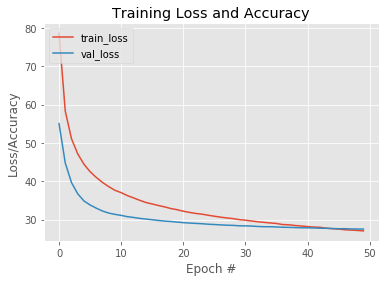

In [91]:
# plot the training loss and accuracy
print ('History keys: {}'.format(model_history.history.keys()))
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, epochs), model_history.history["val_regression_loss"], label="val_regression_loss")
#plt.plot(np.arange(0, epochs), model_history.history["val_classification_loss"], label="val_classification_loss")
#plt.plot(np.arange(0, epochs), model_history.history["classification_acc"], label="classification_acc")
#plt.plot(np.arange(0, epochs), model_history.history["val_classification_acc"], label="val_classification_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("model_training_plot.png")

### Check the predictions.

In [92]:
import json
from keras.models import load_model
from keras.models import model_from_json

# Load the saved model.
saved_model = 'stage2_model_epoch_10.h5'
saved_model_weights = 'stage2_model_epoch_10_weights.h5'
json_model = 'stage2_model.json'
infer_model = load_model(saved_model, custom_objects={'PriorProbability': PriorProbability, 
                                                      'focal_loss_fixed': focal_loss(),
                                                      'softmax': tf.nn.softmax})

In [93]:
start = time.time()
prediction = infer_model.predict_on_batch(np.expand_dims(X_test[0], axis=0))
print("processing time: ", time.time() - start)
print ('Prediction : {}'.format(prediction))

processing time:  0.4889090061187744
Prediction : [array([[ 0.00026348,  0.00203103,  0.0477102 ,  0.00048003,  0.00044745,
         0.00243155,  0.03770346,  0.00041694,  0.08572096,  0.01437806,
         0.0140356 ,  0.00241337,  0.01281908,  0.00044907,  0.00080647,
         0.00149425,  0.0016595 ,  0.0598856 ,  0.16639811,  0.00026362,
         0.02139124,  0.00040773,  0.00341866,  0.00083225,  0.06495046,
         0.00114342,  0.02915228,  0.00034747,  0.20556101,  0.00063821,
         0.00230344,  0.00030429,  0.0007557 ,  0.01417188,  0.04048564,
         0.00032792,  0.00041095,  0.01420562,  0.00093084,  0.00881992,
         0.02660077,  0.04190428,  0.00042424,  0.00033706,  0.00338042,
         0.00375057,  0.00025762,  0.0014349 ,  0.05080274,  0.00040886,
         0.00239472,  0.00071445,  0.0003428 ,  0.00046949,  0.00107384,
         0.00052478,  0.00082004,  0.00052548,  0.00048308,  0.0006607 ,
         0.0003224 ]], dtype=float32), array([[ 0.00042171,  0.00157569, 

### Convert model prediction to labels for validation

In [94]:
def get_score(subject_prediction, object_prediction, relationship_prediction, disable_regress=True):
    subject_max = float(np.amax(subject_prediction))
    object_max = float(np.amax(object_prediction))
    relationship_max = float(np.amax(relationship_prediction))
    return (subject_max + object_max + relationship_max)/3.0

def get_label(lb, softmax_vector):
    a = np.asarray(softmax_vector).reshape(-1)
    b = np.zeros_like(a)
    b[np.argmax(a)] = 1
    return lb.inverse_transform(b.reshape(1, -1))[0]

def convert_prediction_to_label(lb_subject_object, lb_relationship_object, prediction, disable_regress=True):
    # regress output
    start_idx = 0
    if disable_regress is False:
        boxes = prediction[start_idx]
        start_idx +=1

    label_subject_probs = prediction[start_idx]
    label_subject = get_label(lb_subject_object, prediction[start_idx])
    label_object = get_label(lb_subject_object, prediction[start_idx + 1])
    label_relationship = get_label(lb_relationship_object, prediction[start_idx + 2])
    score = get_score(prediction[start_idx], prediction[start_idx + 1], prediction[start_idx + 2])
    if disable_regress is False:
        return (boxes.reshape(-1).tolist(), (label_subject, label_object, label_relationship), score)
    else:
        return ([-1]*8, (label_subject, label_object, label_relationship), score)

print ('Subject label prediction: {}'.format(convert_prediction_to_label(mlb_subject_object,                                                 
                                                                         mlb_relationship,
                                                                         prediction)))

Subject label prediction: ([-1, -1, -1, -1, -1, -1, -1, -1], ('/m/04yx4', '/m/04yx4', 'holds'), 0.23340508341789246)


In [95]:
# Get prediction for test set to evaluate score.
print ('X_test shape: {}'.format(X_test.shape))
start = time.time()
predictions = infer_model.predict(X_test)
print("processing time: ", time.time() - start)

X_test shape: (16645, 600)
processing time:  0.9601843357086182


In [96]:
print ('Prediction[0] shape: {}, prediction[1] shape: {}, prediction[2] shape: {}'.format(
    predictions[0].shape, predictions[1].shape, predictions[2].shape))

Prediction[0] shape: (16645, 61), prediction[1] shape: (16645, 61), prediction[2] shape: (16645, 10)


In [97]:
def get_entry_for_eval(fid, predictions, lb_subject_object, lb_relationship_object, disable_regress=True):
    boxes_labels_tuple = convert_prediction_to_label(lb_subject_object, lb_relationship_object, predictions,
                                                    disable_regress=disable_regress)
    return [fid, boxes_labels_tuple[1][0], boxes_labels_tuple[1][1]] + boxes_labels_tuple[0] + \
            [boxes_labels_tuple[1][2]] + [boxes_labels_tuple[2]]

def process_test_set_predictions(test_dataset, X_test, infer_model, 
                                 lb_subject_object, lb_relationship_object,
                                 disable_regress=True):
    print ('X_test shape: {}'.format(X_test.shape))
    start = time.time()
    predictions = infer_model.predict(X_test)
    print("processing time: ", time.time() - start)
    ret_list = []
    print ('processing entry count: {}'.format(len(test_dataset['id'])))
    for i in range(0, len(test_dataset['id'])):
        fid = test_dataset['id'][i]
        if disable_regress is False:
            eval_output = get_entry_for_eval(fid, 
                                             [predictions[0][i],
                                              predictions[1][i].reshape(1, -1), 
                                              predictions[2][i].reshape(1, -1), 
                                              predictions[3][i].reshape(1, -1)], lb_subject_object, 
                                              lb_relationship_object)
            ret_list.append(eval_output)
        else:
            eval_output = get_entry_for_eval(fid, 
                                             [predictions[0][i].reshape(1, -1), 
                                              predictions[1][i].reshape(1, -1), 
                                              predictions[2][i].reshape(1, -1)], lb_subject_object, 
                                              lb_relationship_object, disable_regress=disable_regress)
            ret_list.append(eval_output)

    return ret_list

def ouput_validation_csv(validation_list, csv_file, prefix='validation', disable_regress=True):
    csv_file_path = os.path.join(prefix, csv_file)
    with open(csv_file_path, mode='w', newline='', encoding='utf8') as f:
        write_one_extra = False
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(
    "ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,Score".split(','))
        for entry in validation_list:
            writer.writerow(entry)
            if write_one_extra is False:
                writer.writerow(entry)  # Hack to write twice to fix error in ooid_vrd_challenge_evaluation.py
                write_one_extra = True

In [98]:
disable_regress=True
validation_list = process_test_set_predictions(model_test_dataset, X_test, infer_model, 
                                               mlb_subject_object, mlb_relationship, 
                                               disable_regress=disable_regress)
ouput_validation_csv(validation_list, csv_file='stage2_model_epoch_10_testset_val.csv')

X_test shape: (16645, 600)
processing time:  0.9924373626708984
processing entry count: 16645


### Filter input csv for evalulation

This is mentioned here:
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/challenge_evaluation.md

In [99]:
def filter_ground_truth_csv(prefix='data/raw', train_csv_fname = 'challenge-2018-train-vrd.csv', 
                            test_csv_fname = 'validation/stage2_model_epoch_10_testset_val.csv',
                            filtered_csv_fname = 'validation/filtered-challenge-2018-train-vrd.csv'):
    
    test_fid_set = set()
    with open(test_csv_fname, mode='r', encoding='utf8') as f:
        rows = csv.reader(f)
        for row in rows:
            test_fid_set.add(row[0])
    
    filtered_truth_rows = []
    with open(os.path.join(prefix, train_csv_fname), mode='r', encoding='utf8') as f:
        rows = csv.reader(f)
        for row in rows:
            if row[0] in test_fid_set:
                filtered_truth_rows.append(row)
        
    with open(filtered_csv_fname, mode='w', newline='', encoding='utf8') as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for entry in filtered_truth_rows:
            writer.writerow(entry)
            
    return filtered_truth_rows

In [100]:
training_csv = 'challenge-2018-train-vrd.csv'
validation_csv = 'validation/stage2_model_epoch_10_testset_val.csv'
filtered_csv_fname = 'validation/filtered-challenge-2018-train-vrd.csv'
filtered_ground_truth_rows = filter_ground_truth_csv(prefix='data/raw', 
                                                     train_csv_fname = 'challenge-2018-train-vrd.csv', 
                                                     test_csv_fname = validation_csv,
                                                     filtered_csv_fname = filtered_csv_fname)
print ('Filtered set size: {}'.format(len(filtered_ground_truth_rows)))

Filtered set size: 109699


### Helpers for mAP calculation without using IOU for now

Only measure triplet detection accuracy per class and across all classes

In [101]:
def get_triplet_to_image_id_dict_from_csv(csv_fname):
    ret_dict = {}
    
    with open(csv_fname, mode='r', encoding='utf8') as f:
        rows = csv.reader(f)
        header_process = False
        relationship_idx = -1
        for row in rows:
            if header_process is False:
                print ('header for {}: {}'.format(csv_fname, row))
                relationship_idx = row.index('RelationshipLabel')
                header_process = True
                continue
            fid = row[0]
            subject_class = row[1]
            object_class = row[2]
            relationship_class = row[relationship_idx]
            boxes = row[3:11]
            k = (subject_class, object_class, relationship_class)
            if k in ret_dict:
                if fid in ret_dict[k]:
                    ret_dict[k][fid].append(boxes)
                else:
                    ret_dict[k][fid] = [boxes]
            else:
                ret_dict[k] = {fid: [boxes]}
    return ret_dict

def get_triplet_to_image_id_dict_from_data_set(model_data_input):
    """
    When not considering bounding box data dimension for train and test set we only have a 
    constrained set of triplets. Get them for evaluation.
    """
    ret_dict = {}

    for fid, boxes, labels_orig in zip(model_data_input['id'], model_data_input['boxes'], 
                                       model_data_input['labels_orig']):
        k = labels_orig
        if k not in ret_dict:
            ret_dict[k] = {}

        if fid not in ret_dict[k]:
            ret_dict[k][fid] = []
  
        ret_dict[k][fid].append(boxes)

    return ret_dict

In [102]:
ground_truth_triplet_dict = get_triplet_to_image_id_dict_from_data_set(model_data_input=model_test_dataset)
model_test_triplet_dict, model_test_rel_dict = get_triplets_from_dataset(model_test_dataset)
testset_triplet_dict = get_triplet_to_image_id_dict_from_csv(csv_fname=validation_csv)

header for validation/stage2_model_epoch_10_testset_val.csv: ['ImageID', 'LabelName1', 'LabelName2', 'XMin1', 'XMax1', 'YMin1', 'YMax1', 'XMin2', 'XMax2', 'YMin2', 'YMax2', 'RelationshipLabel', 'Score']


In [103]:
print ('model test triplet keys length: {}'.format(len(ground_truth_triplet_dict.keys())))
print ('testset triplet_keys lenth: {}'.format(len(testset_triplet_dict.keys())))

model test triplet keys length: 231
testset triplet_keys lenth: 163


In [104]:
def get_per_class_precision_recall_dict(ground_truth_triplet_dict, testset_triplet_dict):
    class_dict = {}
    for triplet, v in testset_triplet_dict.items():
        #print('Triplet: {}'.format(triplet))
        detection_count = len(v.keys())        
        true_positives = 0.0
        ground_truth_count = 0.0
        if triplet in ground_truth_triplet_dict:
            result_fid_set = set(v.keys())
            ground_fid_set = set(ground_truth_triplet_dict[triplet].keys())
            ground_truth_count  = len(ground_fid_set)
            true_positives = len(result_fid_set.intersection(ground_fid_set))
        #print ('+ive: {}, detection_count: {}'.format(true_positives, detection_count))
        precision = float(true_positives)/float(detection_count)
        if ground_truth_count != 0.0:
            recall = float(true_positives)/float(ground_truth_count)
        else:
            recall = None  # Invalid triplet!.
        class_dict[triplet] = (precision, recall)
    return class_dict

In [105]:
triplet_precision_recall = get_per_class_precision_recall_dict(ground_truth_triplet_dict, testset_triplet_dict)

In [106]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input()

Missing label count: 0


### Per triplet precision and recall

List the precision and recall obtained per triplet.

In [108]:
for k, v in triplet_precision_recall.items():
    #print ('Triplet: {}'.format(k))
    if v[1] is not None:
        print ('{}-{}-{}:{},{}'.format(label_dict[k[0]], k[2], label_dict[k[1]], 
            round(float(v[0]), 6), round(float(v[1]), 6)))

Woman-at-Table:0.44,0.010309
Man-holds-Guitar:0.0,0.0
Man-holds-Bottle:0.0,0.0
Man-at-Table:0.26087,0.004428
Chair-at-Table:0.083333,0.000645
Man-on-Chair:0.0,0.0
